In [1]:
from typing import Literal, TypeAlias
from pprint import pprint
import time

import numpy as np
import sklearn
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import seaborn as sns
from tqdm import tqdm

In [2]:
Sample: TypeAlias = list[int | float]
Data: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [5]:
# Activation functions

from abc import ABC, abstractmethod


class ActivationBase(ABC):
    @abstractmethod
    def calc(self, x: Sample) -> list[float]:
        """Apply the activation function to an layer output"""
        pass

    @abstractmethod
    def derivative(self, x: Sample):
        pass

#######################################


class ReLU(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return np.maximum(0, x)

    def derivative(self, x: Sample):
        return self.calc(x=x)


class Sigmoid(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: Sample):
        return x * (1-x)


class Softmax(ActivationBase):
    """returns model 'probabilities' for each class"""

    def calc(self, x: Sample) -> list[float]:
        
        # optimization: make numbers in an array from -inf to 0 because of a np.exp growing
        # and returns an array of floats from 0.0 to 1.0
        max_value = np.max(x)
        x -= max_value

        exp_values = np.exp(x)
        return exp_values / np.sum(exp_values)
    
    def derivative(self, x: Sample):
        pass

In [6]:
# Loss functions


class LossBase(ABC):
    @abstractmethod
    def calc(self, x: Sample, y: Target) -> float:
        """Apply the loss function to an output layer"""
        pass


class MSELoss(LossBase):
    """For regression""" 
    def calc(self, x: Sample, y: Target) -> float:

        loss = (y - x) ** 2

        return np.mean(loss)


class CrossEntropy(LossBase):
    """For classification"""
    def calc(self, x: Sample, y: Target) -> float:
        return -np.sum(y * np.log(x))


In [21]:
a = [1, 100, 22, 99]

f = Softmax()

b = f.calc(a)
print(b)
print(sum(b))

[7.39262147e-44 7.31058579e-01 9.74950551e-35 2.68941421e-01]
1.0


In [7]:
class Dataset:
    def __init__(self, data: Data, targets: Targets) -> None:
        self.data: Data = data
        self._len = len(data)
        self.targets: Targets = targets

    def __len__(self) -> int:
        return self._len
    
    def __getitem__(self, index) -> Sample:
        return self.data[index]
    
    def __iter__(self):
        return iter(self.data)


In [8]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation: ActivationBase) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        
        self.weights = self._init_weights()
        self.bias = self._init_bias()
        self.output = []

        self.activation = activation
    
    def _init_weights(self) -> list[float]:
        scale = 1/max(1., (2+2)/2.)
        limit = np.sqrt(3.0 * scale)

        # return np.random.randn(self.n_neurons, self.n_inputs) #* 0.1
    
        weights = np.random.uniform(-limit, limit, size=(self.n_neurons, self.n_inputs))
        return weights
    
    def _init_bias(self) -> list[float]:
        return np.random.randn(1)
    
    def forward(self, inputs) -> None:
        # print(f"{inputs = }")
        # print(f"{self.weights = }")

        output = np.matmul( self.weights, inputs.T)

        output += self.bias

        self.output = self.activation.calc(output)
        # print(f"{self.output = }")
    

    # def backward(self, grad, learning_rate: float, output):
        
    #     # print(f"{self.weights = }")
    #     print(f"{output = }")
    #     print(f"{grad = }")

    #     print()

    #     weights_new = self.weights - grad * output * learning_rate
    #     # print(f"{weights_new = }")
    #     # print('\n\n')

    #     self.weights = weights_new


Layers: TypeAlias = list[Linear]

In [115]:
class Model:
    def __init__(self, layers: Layers, loss: LossBase, n_epoch: int = 1, learning_rate: float = 0.01, verbose: bool = True):
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss
        
        self.n_epoch = n_epoch
        self.learning_rate = learning_rate
        self.verbose = verbose

    def fit(self, dataset: Dataset) -> list[float]:
        losses_by_epoch = []

        range_epoch = range(self.n_epoch)
        if self.verbose:
            range_epoch = tqdm(range_epoch, desc="epochs", position=0)

        for epoch in range_epoch:
            epoch_losses = []

            for i,sample in enumerate(dataset):
                sample = np.array(sample)
                # sample = sample.reshape(1,len(sample))


                # Forward pass
                self.layers[0].forward(inputs=sample) # input layer
                for j in range(1, self._layers_len):
                    self.layers[j].forward(inputs=self.layers[j-1].output)

                target = dataset.targets[i]
                

                # Calc loss
                output_error = self.calc_loss(target=target)
                epoch_losses.append(output_error)

                


                # Backward pass
                # backward from output to input layer
                # propagate gradients using chain rule

                delta =  self.layers[-2].activation.derivative(x=self.layers[-2].output) * output_error

                print("output_error", output_error)
                print("delta", delta)


                for i in range(self._layers_len - 2, 0, -1):
                    print("weights", self.layers[i+1].weights)
                    print("delta", delta)

                    error = np.dot(self.layers[i+1].weights.T, delta)
                    delta =  self.layers[i].activation.derivative(x=self.layers[i].output) * error
                    
            mean_loss = np.mean(epoch_losses)
            losses_by_epoch.append(mean_loss)
        
        return losses_by_epoch
    
    def predict(self, sample: Sample) -> list[float]:
        sample = np.array(sample)
        sample = sample.reshape(1,len(sample))

        self.layers[0].forward(inputs=sample)
                
        for j in range(1, self._layers_len):
            self.layers[j].forward(inputs=self.layers[j-1].output)
        
        predict = self.layers[-1].output
        return predict
    
    def calc_loss(self, target: Target) -> float:
        output_layer = self.layers[-1]
        output = output_layer.output

        loss = self.loss.calc(x=output, y=target)
        return loss

    
    def set_weights(self, weights: Weights) -> None:
        for w,layer in zip(weights, self.layers):
            layer.weights = w

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

In [10]:
X_train = [
    # [1,2,3,4],
    [4,3,2,1]
]



# X_train = [
#     [[1,2,3], [1,2,3], [1,2,3]], # photo
# ]

y_train = [1,]



train_dataset = Dataset(data=X_train, targets=y_train)
# val_dataset = Dataset(data=X_val, targets=y_val)

In [125]:
# input and output layers must be with equal numbers

layers = [
    Linear(4,13, activation=Sigmoid()),
    Linear(13,4, activation=Sigmoid()),
    Linear(4,2, activation=Sigmoid()),
    Linear(2,4, activation=Sigmoid()),
    Linear(4,2, activation=Sigmoid()),
    Linear(2,100, activation=Sigmoid()),
    Linear(100,1, activation=Sigmoid()),
    Linear(1,100, activation=Sigmoid()),
    Linear(100,100, activation=Softmax()),
]

model = Model(layers=layers, loss=MSELoss(), n_epoch=1, verbose=0)


model.fit(dataset=train_dataset)

output_error 0.9826926579181234
delta [0.24422102 0.24343578 0.24392697 0.24350237 0.24384492 0.24334213
 0.24391293 0.24334608 0.24334231 0.24341844 0.24373281 0.24345932
 0.24339405 0.24390948 0.24371653 0.24403863 0.24401004 0.24423316
 0.24358916 0.24350295 0.243364   0.24420097 0.24354119 0.24422807
 0.24339781 0.24360016 0.24414504 0.24418392 0.24406094 0.24339365
 0.24329724 0.24336579 0.24378104 0.24374805 0.24338903 0.24402291
 0.24328976 0.24352151 0.24349825 0.24386744 0.24420559 0.2440817
 0.24421115 0.24401052 0.24362556 0.24391405 0.24417258 0.24409929
 0.24347132 0.24388627 0.24386489 0.24417797 0.24334637 0.24416905
 0.24420178 0.2440782  0.24338741 0.24403667 0.24343162 0.24407789
 0.24344488 0.24328405 0.24366437 0.24377841 0.24408724 0.24422144
 0.24385528 0.24394752 0.24407315 0.24399598 0.2435094  0.24417059
 0.24350959 0.24354083 0.24405683 0.2435223  0.24401959 0.24379082
 0.2434787  0.24355171 0.24332596 0.2437867  0.24361155 0.24339811
 0.24347769 0.24420437 0.

[0.9826926579181234]

In [364]:
model.layers[1].weights

array([[ 0.87616528,  0.8770434 , -1.07185091, -0.3473528 ,  0.07240868,
        -0.0397271 ,  0.04991074, -1.00090593,  0.99031344,  1.10922691,
         0.56103235, -0.71546477,  1.19246648],
       [ 0.29093634,  0.58343993,  0.06555826,  0.26530925, -0.87390265,
        -0.76867888, -0.39083652, -0.94488054,  0.90105738,  0.65674802,
         0.83505957, -0.72995415, -1.15744424],
       [ 0.59840803,  0.97942934, -0.92458376, -1.03876575, -0.6212136 ,
        -0.08884953,  0.68199734,  0.25303518, -0.47230019,  1.11874919,
         0.13748123,  0.1428907 ,  0.72724899],
       [-0.09438416, -0.39631527,  0.96266206,  0.61768845, -0.42897597,
         1.05387946,  0.50110398,  1.00928054, -0.98790323,  0.02746748,
         0.95923375, -0.06502083, -0.64327335]])

In [369]:
model.fit(dataset=train_dataset)

[0.9391043  0.00322892 0.00930119 0.94782751 0.91798714 0.01339995
 0.00372608 0.00276383 0.03399139 0.96232475 0.86889642 0.67765143
 0.00543836]

[0. 0. 0. 0.]


ValueError: shapes (13,) and (4,) not aligned: 13 (dim 0) != 4 (dim 0)

# Load dataset

In [967]:
dataset = load_iris()

In [970]:
dataset.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [1089]:
X, y = dataset['data'], dataset['target']

In [ ]:
X

In [1091]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# One-hot encoding

In [1093]:
labels = set(y)
labels_len = len(labels)

labels

{np.int64(0), np.int64(1), np.int64(2)}

In [1094]:
y_1 = []

for i in y:
    l = [0] * labels_len
    l[i] = 1
    y_1.append(l)
y_1

[[1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0,

# Split

In [1228]:
X_train, X_val, y_train, y_val = train_test_split(X, y_1, train_size=0.8)

In [1229]:
train_dataset = Dataset(data=X_train, targets=y_train)
val_dataset = Dataset(data=X_val, targets=y_val)

# Model

In [1267]:
layers = [
    Linear(4,10, activation=ReLU()),
    Linear(10,20, activation=ReLU()),
    Linear(20,100, activation=ReLU()),
    Linear(100,10, activation=ReLU()),
    Linear(10,3, activation=Softmax()),
]

model = Model(layers=layers, loss=MSELoss(), n_epoch=10, verbose=1)

In [1268]:
losses = model.fit(dataset=train_dataset)

epochs: 100%|██████████| 10/10 [00:00<00:00, 41.55it/s]


# Plots

<Axes: >

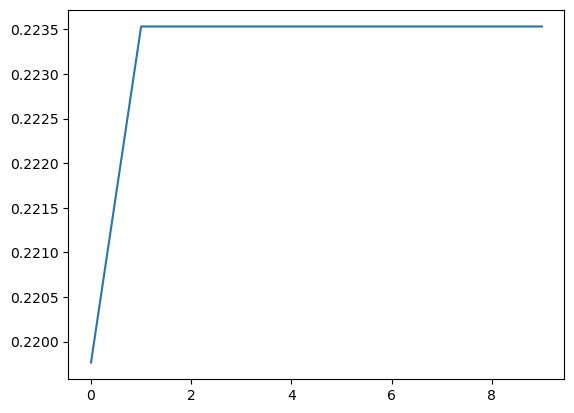

In [1269]:
sns.lineplot(losses)

In [1240]:
X_val[0]

array([4.3, 3. , 1.1, 0.1])

In [1241]:
model.predict(X_train[1]), y_train[1]

(array([[0.37434921, 0.37134219, 0.2543086 ]]), [1, 0, 0])

In [1242]:
model.predict(X_val[1]), y_val[1]

(array([[0.23116393, 0.37761343, 0.39122264]]), [0, 1, 0])

In [1270]:
true_count = 0
all_count = 0

for sample,target in zip(X_train, y_train):
    pred = model.predict(sample=sample)

    pred = np.where(pred[0] >= max(pred[0]), 1, 0)
    # print(pred)
    # print(target)

    if list(pred) == target:
        true_count += 1
    all_count += 1 


acc = true_count / all_count
acc

0.3416666666666667

In [1215]:
np.argmax([1,0,0])

np.int64(0)